In [1]:
import io
from google.colab import files
uploaded = files.upload()

Saving Hate Speech.csv to Hate Speech.csv


In [2]:
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['Hate Speech.csv']))

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
print(df['class'].unique())

[2 1 0]


In [ ]:
# print(df.iloc[0, 'tweet']) --> ValueError

# If you want to access rows or columns based on their labels (in your case, 'tweet'), you should use the loc indexer:
print(df.loc[0, 'tweet'])


!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...


In [ ]:
# Group by `class` and calculate mean values for relevant columns
class_mapping = df.groupby('class')[['hate_speech', 'offensive_language', 'neither']].mean()
print(class_mapping)

# Examine the Relationship Between class and Other Columns:
# Group the data by class and calculate the average values of the columns hate_speech, offensive_language, and neither. This can reveal the dominant
# category corresponding to each class.

# neither --> 2
# offensive_language --> 1
# hate_speech --> 0


       hate_speech  offensive_language   neither
class                                           
0         2.256643            0.755944  0.095804
1         0.180459            3.003544  0.084888
2         0.062935            0.264233  2.845544


In [ ]:
df.shape

(24783, 7)

In [ ]:
print(df.isna().sum())

# missing_column = df['column_name'].isnull()
# print(missing_column) --> Return in the form of True or False

# missing_count = df.isnull().sum()
# print(missing_count)


Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


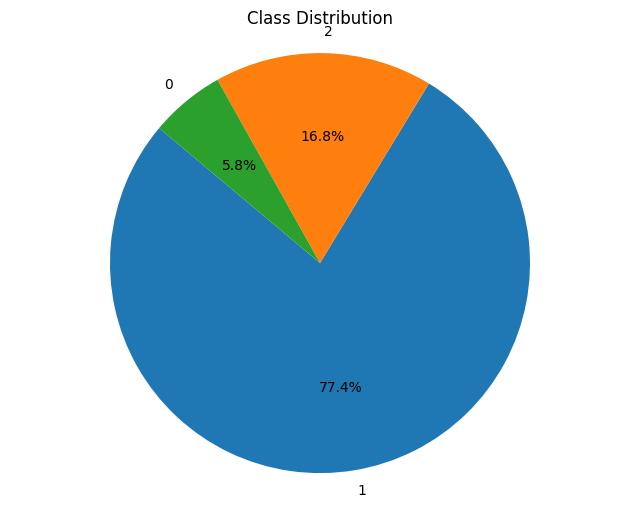

In [3]:
import matplotlib.pyplot as plt

# Calculate class counts
class_counts = df['class'].value_counts()

plt.figure(figsize = (8, 6))
plt.pie(class_counts, labels = class_counts.index, autopct = '%1.1f%%', startangle = 140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

# As you can see there is imbalanced class; The largest proportion in the pie chart belongs to offensive_language.

In [4]:
df1 = df.copy()

In [5]:
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

# Download the punkt tokenizer
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(
        r'[^\w\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF]',
        '', text
    )  # Remove emojis and special characters
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(cleaned_tokens)

df1['Cleaned_tweet'] = df1['tweet'].apply(clean_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
!pip install gensim

In [7]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from joblib import dump, load

In [8]:
# Tokenize the 'Preprocessed_Review' column
tokenized_reviews = df1['Cleaned_tweet'].apply(lambda x: x.split())

# Train the Word2Vec model
word2vec_model = Word2Vec(
    sentences = tokenized_reviews,
    vector_size = 100,
    window = 5,
    min_count = 1,
    workers = 4
)

# Save the Word2Vec model
dump(word2vec_model, 'word2vec_model.joblib')

# Function to compute average Word2Vec embeddings for a text
def get_avg_word2vec(tokens, model, vector_size):
    # Filter tokens that are in the Word2Vec vocabulary
    valid_tokens = [token for token in tokens if token in model.wv.key_to_index]
    if not valid_tokens:
        return np.zeros(vector_size)
    # Compute the mean of the word vectors
    return np.mean([model.wv[token] for token in valid_tokens], axis = 0)

# Reload the Word2Vec model (if needed after saving it)
word2vec_model = load('word2vec_model.joblib')

# Compute and save the embeddings
df1['Word2Vec_Embedding'] = tokenized_reviews.apply(lambda tokens: get_avg_word2vec(tokens, word2vec_model, 100))

# Save the embeddings column
dump(df1['Word2Vec_Embedding'], 'word2vec_embeddings.joblib')

['word2vec_embeddings.joblib']

In [9]:
X = np.stack(df1['Word2Vec_Embedding'].values)
y = df1['class'].values

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
from imblearn.over_sampling import SMOTE

desired_distribution = {
    0: int(0.9 * 15358),  # 90% of the majority class
    2: int(0.9 * 15358),
    1: 15358
}

# Initialize SMOTE with the custom sampling strategy
smote = SMOTE(sampling_strategy = desired_distribution, random_state = 42)
x_train_re, y_train_re = smote.fit_resample(x_train, y_train)


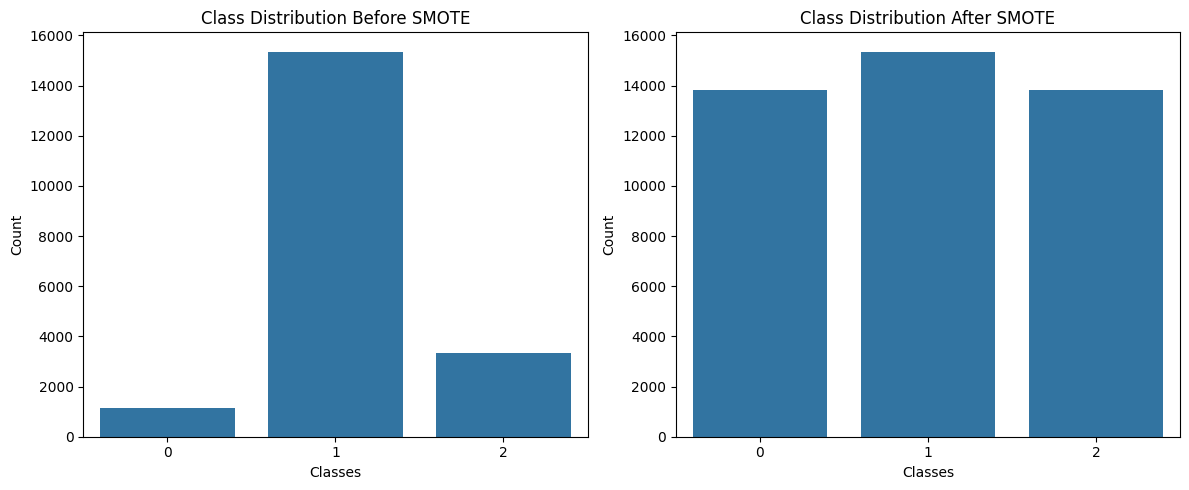

In [12]:
import seaborn as sns

# Plot class distribution before SMOTE
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x = y_train)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Classes")
plt.ylabel("Count")

# Plot class distribution after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x = y_train_re)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [13]:
import joblib
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_re)
joblib.dump(scaler, 'scaler.joblib')
x_test_scaled = scaler.transform(x_test)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
model = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 8,
    min_samples_split = 5,
    min_samples_leaf = 3,
    max_features = 'sqrt',
    random_state = 42
)

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

y_pred_cv = cross_val_predict(model, x_train_scaled, y_train_re, cv = kfold)
conf_matrix = confusion_matrix(y_train_re, y_pred_cv)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_train_re, y_pred_cv))


Confusion Matrix:
 [[ 8055  3532  2235]
 [ 1279 12711  1368]
 [ 1032   773 12017]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.58      0.67     13822
           1       0.75      0.83      0.79     15358
           2       0.77      0.87      0.82     13822

    accuracy                           0.76     43002
   macro avg       0.76      0.76      0.76     43002
weighted avg       0.76      0.76      0.76     43002



In [17]:
!pip install xgboost

In [18]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 6,
    reg_alpha = 1.0,
    reg_lambda = 1.0,
    random_state = 42
)

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

y_pred = cross_val_predict(xgb_model, x_train_scaled, y_train_re, cv = kfold)
conf = confusion_matrix(y_train_re, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_train_re, y_pred))

Confusion Matrix:
 [[ 8055  3532  2235]
 [ 1279 12711  1368]
 [ 1032   773 12017]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83     13822
           1       0.87      0.82      0.84     15358
           2       0.85      0.94      0.89     13822

    accuracy                           0.86     43002
   macro avg       0.85      0.86      0.85     43002
weighted avg       0.86      0.86      0.85     43002



In [22]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = ConvergenceWarning)
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty = 'l2', solver = 'lbfgs', max_iter = 200, C = 1.0, random_state = 42)

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

y_pred = cross_val_predict(logreg, x_train_scaled, y_train_re, cv = kfold)
conf = confusion_matrix(y_train_re, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_train_re, y_pred))

Confusion Matrix:
 [[ 8055  3532  2235]
 [ 1279 12711  1368]
 [ 1032   773 12017]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.65      0.69     13822
           1       0.81      0.78      0.80     15358
           2       0.79      0.92      0.85     13822

    accuracy                           0.78     43002
   macro avg       0.78      0.78      0.78     43002
weighted avg       0.78      0.78      0.78     43002

